# Topic modeling with LDA

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
import math
from gensim import corpora, models
import pprint
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

At the end of preprocessing/edmunds_reviews.ipynb I have checked and removed rows containg null values, but it seems that the final "to_csv" adds 900 null values. So these values should be removed again.

In [2]:
path = "../data/final_edmunds_reviews.csv"
cars = pd.read_csv(path)
cars.dropna(subset=["Review"], inplace=True)
cars.head(2)

,Vehicle_Title,Review_Title,Review,Rating
0,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"New Beetle- Holds up well & Fun to Drive, but ...",i have beetle convertible 45 year andhave over...,4.5
1,2007 Volkswagen New Beetle Convertible 2.5 PZE...,Quality Review,we bought car new 2007 generally satisfied mec...,4.5


In [3]:
cars.isna().sum()

Vehicle_Title    0
Review_Title     0
Review           0
Rating           0
dtype: int64

### Data visualization

#### Count the occurrences of each unique rating value

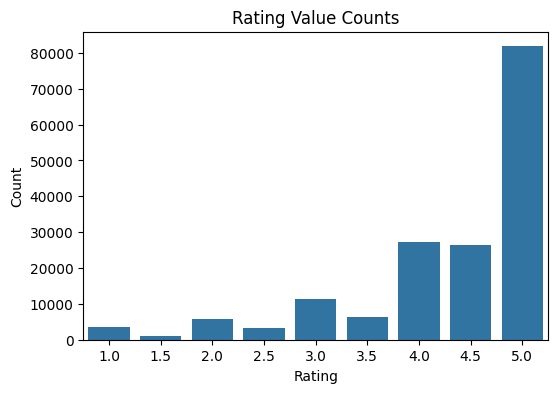

In [ ]:
rating_counts = cars["Rating"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title("Rating Value Counts")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

#### Most common words

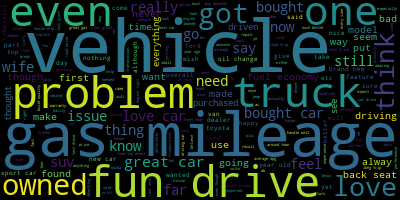

In [ ]:
all_reviews = ",".join(list(cars["Review"].values))
wordcloud = WordCloud(
    background_color="black", max_words=5000, contour_width=3, contour_color="yellow"
)
wordcloud.generate(all_reviews)
wordcloud.to_image()

### Modeling

#### Extract TF-IDF features

In [4]:
reviews_list = cars["Review"].tolist()
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,  # Exclude words that occur in more than 95% of documents
    min_df=2,  # Exclude words that occur in fewer than 2 documents
    ngram_range=(1, 1),
)
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_list)

#### LDA

##### Sklearn

Calculate coherence score:

In [ ]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)


def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence


def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [ ]:
# (testing) select a random number of topics before finding the optimal number
num_topics = 5

model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
model.fit(tfidf_matrix)

perplexity = model.perplexity(tfidf_matrix)
log_likelihood = model.score(tfidf_matrix)
avg_coherence = get_average_topic_coherence(
    tfidf_matrix, model.components_, n_top_words=20
)

print(f"Perplexity: {perplexity}")
print(f"Log Likelihood: {log_likelihood}")
print(f"Coherence score: {avg_coherence}")

Perplexity: 7099.245586779932
Log Likelihood: -8736536.257122194
Coherence score: -355.9809538721655


##### Gensim

In [5]:
# data needs to have the following structure: list of lists of words (list of sentences)
num_topics = 5
tokenized_reviews = [review.split() for review in reviews_list]
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(review) for review in tokenized_reviews]

* Example of using LDA from gensim

In [ ]:
lda_model = models.LdaMulticore(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    chunksize=100,
    passes=10,
)

In [ ]:
coherence_model = CoherenceModel(
    model=lda_model,
    texts=tokenized_reviews,
    dictionary=dictionary,
    coherence="c_v",
)
coherence_lda_score = coherence_model.get_coherence()
perplexity_score = lda_model.log_perplexity(doc_term_matrix)

print("Coherence score:", coherence_lda_score)
print("Perplexity score:", perplexity_score)

#### Determining the optimal number of topics

In [10]:
start = 5
end = 15  # TODO: start = 10 end = 22
step = 1
topics_range = range(start, end + 1, step)
coherence_scores = []

for num_topics in topics_range:
    model = models.LdaMulticore(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
    )
    coherence_model = CoherenceModel(
        model=model, texts=tokenized_reviews, dictionary=dictionary, coherence="c_v"
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

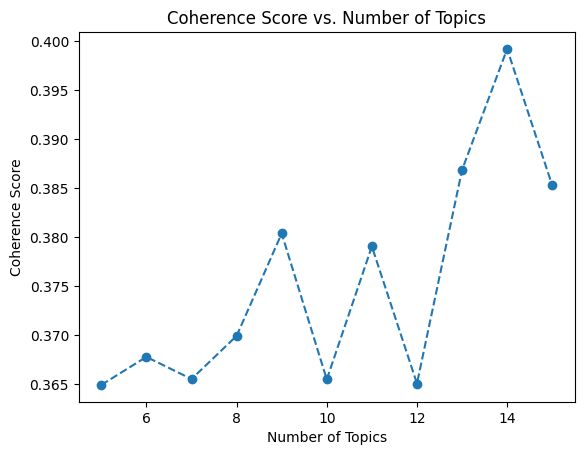

In [11]:
plt.plot(topics_range, coherence_scores, marker="o", linestyle="--")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

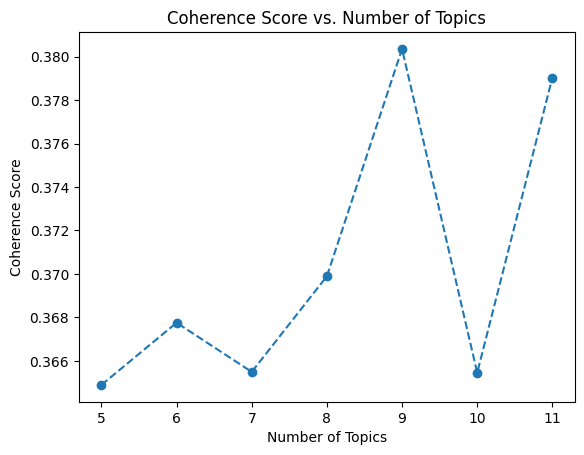

In [15]:
plt.plot(topics_range[:-4], coherence_scores[:-4], marker="o", linestyle="--")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

In [16]:
hdp_model = models.HdpModel(corpus=doc_term_matrix, id2word=dictionary)
hdp_topics = hdp_model.print_topics()
num_topics = len(hdp_topics)
print("Optimal Number of Topics:", num_topics)

Optimal Number of Topics: 20


#### Hyperparameters tuning with fixed number of topics

In [ ]:
alpha_values = ["symmetric", "auto"]
eta_values = [0.01, 0.1, 0.3, 0.5]
NUM_TOPICS = 15  # TODO

best_coherence = -1
best_params = {}

for alpha in alpha_values:
    for eta in eta_values:
        lda_model = models.LdaMulticore(
            corpus=doc_term_matrix,
            id2word=dictionary,
            num_topics=NUM_TOPICS,
            alpha=alpha,
            eta=eta,
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=tokenized_reviews,
            dictionary=dictionary,
            coherence="c_v",
        )
        coherence_score = coherence_model.get_coherence()

        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_params = {"alpha": alpha, "eta": eta}

print("Best parameters:", best_params)
print("Best coherence score:", best_coherence)

#### Final model using best params

In [ ]:
model = models.LdaMulticore(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=15,
    random_state=42,
    chunksize=100,
)

In [13]:
for topic in model.print_topics():
    print(topic)

(0, '0.086*"i" + 0.031*"car" + 0.013*"it" + 0.010*"the" + 0.008*"get" + 0.007*"driving" + 0.007*"like" + 0.007*"have" + 0.006*"mile" + 0.006*"one"')
(1, '0.049*"i" + 0.024*"the" + 0.018*"truck" + 0.014*"jeep" + 0.010*"car" + 0.010*"it" + 0.007*"back" + 0.007*"get" + 0.006*"4x4" + 0.006*"drive"')
(2, '0.034*"i" + 0.016*"car" + 0.013*"great" + 0.011*"mile" + 0.010*"mileage" + 0.009*"good" + 0.007*"mpg" + 0.007*"gas" + 0.007*"reliable" + 0.007*"bought"')
(3, '0.041*"i" + 0.028*"car" + 0.027*"the" + 0.018*"it" + 0.016*"great" + 0.016*"seat" + 0.011*"drive" + 0.009*"love" + 0.008*"like" + 0.008*"back"')
(4, '0.039*"i" + 0.025*"car" + 0.011*"like" + 0.009*"the" + 0.007*"transmission" + 0.007*"it" + 0.006*"vehicle" + 0.006*"driving" + 0.006*"get" + 0.005*"would"')
(5, '0.040*"mpg" + 0.025*"mile" + 0.021*"i" + 0.012*"mph" + 0.012*"average" + 0.010*"highway" + 0.009*"trip" + 0.008*"city" + 0.008*"the" + 0.008*"it"')
(6, '0.032*"i" + 0.022*"car" + 0.019*"the" + 0.009*"it" + 0.008*"great" + 0.008

#### Assign topics to the dataset

In [19]:
print(model.get_document_topics(doc_term_matrix[0]))
print(model.get_document_topics(doc_term_matrix[1]))
print(model.get_document_topics(doc_term_matrix[2]))

[(1, 0.7067806), (3, 0.25374705)]
[(5, 0.8090588), (7, 0.1799683)]
[(0, 0.6319574), (7, 0.34395203)]


In [41]:
def get_topic_info(model, review):
    topics = model.get_document_topics(review)
    topics_dict = {f"topic_{topic}": prob for topic, prob in topics}
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    return pd.Series(
        [dominant_topic] + list(topics_dict.values()),
        index=["dominant_topic"] + list(topics_dict.keys()),
    )

In [42]:
tmp_df = pd.DataFrame()
tmp_df = cars.copy()

* add index of dominant topic and topic probabilities to the dataframe

In [43]:
topic_info = tmp_df["Review"].apply(
    lambda review: get_topic_info(
        model=model, review=dictionary.doc2bow(review.split())
    )
)
tmp_df = pd.concat([tmp_df, topic_info], axis=1)
tmp_df.head(3)

,Vehicle_Title,Review_Title,Review,Rating,dominant_topic,topic_1,topic_3,topic_5,topic_7,topic_0,topic_4,topic_6,topic_10,topic_8,topic_9,topic_14,topic_2,topic_12,topic_11,topic_13
0,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"New Beetle- Holds up well & Fun to Drive, but ...",i have beetle convertible 45 year andhave over...,4.5,1.0,0.706866,0.253662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007 Volkswagen New Beetle Convertible 2.5 PZE...,Quality Review,we bought car new 2007 generally satisfied mec...,4.5,5.0,NaN,NaN,0.809212,0.179815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007 Volkswagen New Beetle Convertible Triple ...,Adore it,i adore new beetle even though i am male i get...,4.5,0.0,NaN,NaN,NaN,0.314166,0.47292,0.190677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
tmp_df.isna().sum()

Vehicle_Title          0
Review_Title           0
Review                 0
Rating                 0
dominant_topic         0
topic_1           129927
topic_3           105091
topic_5           132059
topic_7           112039
topic_0           103081
topic_4           133860
topic_6           108555
topic_10          101224
topic_8           111445
topic_9           111087
topic_14          116228
topic_2           136179
topic_12          140676
topic_11          143988
topic_13          161080
dtype: int64

In [52]:
# cast to int
tmp_df["dominant_topic"] = tmp_df["dominant_topic"].astype(int)

# fill all the NaN values with 0 (values from columns starting with keyword 'topic')
topic_columns = tmp_df.columns[tmp_df.columns.str.startswith("topic")]
tmp_df[topic_columns] = tmp_df[topic_columns].fillna(0)

# sort topic columns
sorted_topic_columns = sorted(topic_columns, key=lambda x: int(x.split('_')[1]))
base_columns = ["Vehicle_Title", "Review_Title", "Review", "Rating", "dominant_topic"]
tmp_df = tmp_df[base_columns + sorted_topic_columns]

In [53]:
tmp_df.head(3)

,Vehicle_Title,Review_Title,Review,Rating,dominant_topic,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"New Beetle- Holds up well & Fun to Drive, but ...",i have beetle convertible 45 year andhave over...,4.5,1,0.00000,0.706866,0.0,0.253662,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2007 Volkswagen New Beetle Convertible 2.5 PZE...,Quality Review,we bought car new 2007 generally satisfied mec...,4.5,5,0.00000,0.000000,0.0,0.000000,0.000000,0.809212,0.0,0.179815,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2007 Volkswagen New Beetle Convertible Triple ...,Adore it,i adore new beetle even though i am male i get...,4.5,0,0.47292,0.000000,0.0,0.000000,0.190677,0.000000,0.0,0.314166,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Find similarities between a new input text and the reviews using the topic probabilities

* preprocess input text

In [ ]:
lemmatizer = WordNetLemmatizer()
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = stopwords.words("english")
stopwords_dict = Counter(stop_words)

In [71]:
def preprocess_text(input):
    def remove_punction_and_contractions(text):
        return re.sub(r'[^\w\s]', '', contractions.fix(str(text)))
    
    def remove_stopwords_and_lemmatize(text):
        text = " ".join(
            [
                lemmatizer.lemmatize(word.lower())
                for word in text.split()
                if word.lower() not in stopwords_dict
            ]
        )
        return text
    return remove_stopwords_and_lemmatize(remove_punction_and_contractions(input))

input = "I've bought a new Volvo. It's the best. I want another one."
preprocess_text(input)

'bought new volvo best want another one'

* calculate topic probabilities distribution for the new input text

In [72]:
def get_topic_distribution(input, model):
    input_words = input.split()
    vectorized_input = dictionary.doc2bow(input_words)
    probab_distribution = model.get_document_topics(vectorized_input)
    return probab_distribution

get_topic_distribution(input, model)

[(8, 0.66537213), (10, 0.21081316)]

* convert LDA topic distributions to vectors for similarity scores
* calculate cosine similarity
* rank items

In [77]:
def create_input_prob_dict(input, model, num_topics):
    input_distribution = get_topic_distribution(input, model)
    input_topic_dict = {}

    for topic_idx, prob in input_distribution:
        input_topic_dict[topic_idx] = prob
    
    for topic_idx in range(0, num_topics):
        if not input_topic_dict.get(topic_idx):
            input_topic_dict[topic_idx] = 0.0
    return dict(sorted(input_topic_dict.items()))

create_input_prob_dict(input, model, num_topics=15)

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.6648847,
 9: 0.0,
 10: 0.21130061,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0}

In [79]:
# extract columns corresponding to the topic distribution
reviews_distributions = tmp_df[[f"topic_{idx}" for idx in range(15)]]

In [80]:
# convert input topic dictionary to a dataframe row
input_topic_dict = create_input_prob_dict(input, model, num_topics=15)
input_text_df = pd.DataFrame(input_topic_dict, index=[0])


In [86]:
# compute similarity scores
similarity_scores = cosine_similarity(input_text_df, reviews_distributions)
tmp_df["SimilarityScore"] = similarity_scores[0]
top_similar_rows = tmp_df.nlargest(5, "SimilarityScore")
top_car_titles = top_similar_rows["Vehicle_Title"].tolist()
tmp_df.drop("SimilarityScore", axis=1, inplace=True)

top_car_titles

['2003 Volkswagen New Beetle Convertible GLS 2dr Convertible (2.0L 4cyl 5M)',
 '2003 Volkswagen New Beetle Convertible GLS 2dr Convertible (1.8L 4cyl Turbo 5M)',
 '2006 Volkswagen New Beetle Hatchback 2.5 2dr Hatchback (2.5L 5cyl 5M)',
 '2000 Volkswagen New Beetle Diesel GLS TDi 2dr Hatchback',
 '2000 Volkswagen New Beetle Hatchback GLS 2dr Hatchback']

In [85]:
top_similar_rows

,Vehicle_Title,Review_Title,Review,Rating,dominant_topic,topic_0,topic_1,topic_2,topic_3,topic_4,...,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,SimilarityScore
47,2003 Volkswagen New Beetle Convertible GLS 2dr...,lemon beetle,i spent 8000 trying get beetle stop jerking wi...,3.5,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.966656,0.0,0.0,0.0,0.0,0.0,0.0,1.0
105,2003 Volkswagen New Beetle Convertible GLS 2dr...,opened can,buy it 4 problem convertible top part available,2.5,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.896273,0.0,0.0,0.0,0.0,0.0,0.0,1.0
692,2006 Volkswagen New Beetle Hatchback 2.5 2dr H...,Never Again,this lease become bane existence the car broke...,2.5,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.981684,0.0,0.0,0.0,0.0,0.0,0.0,1.0
727,2000 Volkswagen New Beetle Diesel GLS TDi 2dr ...,I Love My Diesel Bug,i have never car i loved drive much i always c...,5.0,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.966636,0.0,0.0,0.0,0.0,0.0,0.0,1.0
770,2000 Volkswagen New Beetle Hatchback GLS 2dr H...,I hate Volkswagen!,this car nightmare i hate much i since january...,2.5,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.983005,0.0,0.0,0.0,0.0,0.0,0.0,1.0
